# An all-sky ALMA Archive search for some target lines within a given redshift range

## Uses the `ALMAxmatch` module's `runPayloadQueryWithLines` method

### Import the `ALMAxmatch` module
- This requires adding a custom `astroquery` module to the python path for now (due to a bug in the release date format that should be fixed in the next release).

In [2]:
import sys
sys.path = ['/Users/thbrown/astroquery'] + sys.path

Import module and print valid payload keywords

In [3]:
import sys
sys.path = ['/Users/thbrown/ALMA/think_tank_code/tools/archiveDev'] + sys.path
from ALMAxmatch import archiveSearch

## 1. Define lines of interest and redshift range

### Lines:


1. C$^{18}$O ($J=1-0$) @ 109.78217340 GHz rest frequency
2. $^{13}$CO ($J=1-0$) @ 110.20135430 GHz rest frequency
3. $^{12}$CO ($J=1-0$) @ 115.27120180 GHz rest frequency
4. C$^{18}$O ($J=2-1$) @ 219.56035410 GHz rest frequency
5. $^{13}$CO ($J=2-1$) @ 220.39868420 GHz rest frequency
6. $^{12}$CO ($J=2-1$) @ 230.53800000 GHz rest frequency
7. C$^{18}$O ($J=3-2$) @ 329.33055250 GHz rest frequency
8. $^{13}$CO ($J=3-2$) @ 330.58796530 GHz rest frequency
9. $^{12}$CO ($J=3-2$) @ 345.79598990 GHz rest frequency


In [4]:
"""# rest frame frequencies
rf_C18O_10 = 109.78217340 # C18O J=1-0
rf_13CO_10 = 110.20135430 # 13CO J=1-0
rf_12CO_10 = 115.27120180 # 12CO J=1-0 
rf_C18O_21 = 219.56035410 # C18O J=2-1
rf_13CO_21 = 220.39868420 # 13CO J=2-1
rf_12CO_21 = 230.53800000 # 12CO J=2-1
rf_C18O_32 = 329.33055250 # C18O J=3-2
rf_13CO_32 = 330.58796530 # 13CO J=3-2
rf_12CO_32 = 345.79598990 # 12CO J=3-2


rest_frequencies = [rf_C18O_10, rf_13CO_10, rf_12CO_10, 
                    rf_C18O_21, rf_13CO_21, rf_12CO_21, 
                    rf_C18O_32, rf_13CO_32, rf_12CO_32] # list of rest frequencies
line_names = ['C18O J=1-0', '13CO J=1-0', '12CO J=1-0',
              'C18O J=2-1', '13CO J=2-1', '12CO J=2-1',
              'C18O J=3-2', '13CO J=3-2', '12CO J=3-2'] # column names for observed boolean flags """

In [4]:
# rest frame frequencies
rf_C18O_10 = 109.78217340 # C18O J=1-0
rf_13CO_10 = 110.20135430 # 13CO J=1-0
rf_C18O_21 = 219.56035410 # C18O J=2-1
rf_13CO_21 = 220.39868420 # 13CO J=2-1
rf_C18O_32 = 329.33055250 # C18O J=3-2
rf_13CO_32 = 330.58796530 # 13CO J=3-2


rest_frequencies = [rf_C18O_10, rf_13CO_10, 
                    rf_C18O_21, rf_13CO_21, 
                    rf_C18O_32, rf_13CO_32] # list of rest frequencies
line_names = ['C18O J=1-0', '13CO J=1-0', '12CO J=1-0',
              'C18O J=2-1', '13CO J=2-1', '12CO J=2-1',
              'C18O J=3-2', '13CO J=3-2', '12CO J=3-2'] # column names for observed boolean flags 

### Search Redshift Range:

Search for the following lines at $0.0 \leq z \leq 0.05$:

In [5]:
# search redshift range
redshift_range = [0.0,0.05]

## 2. Run the archive search


### What does `runPayloadQueryWithLines` do?
1. Calculate min and max frequencies for the target lines in the redshift range
2. Create a "payload" dictionary of keywords (including frequency) that are accepted by the ALMA Archive system. See 
3. Query the service using `astroquery.alma.Alma.query` and return a table object, selecting only science data
4. Cross-match these observations with NED, returning the results in the following astropy tables:

    `archiveSearch.queryResults`: ALMA Archive information for observations that match a NED object name and have a redshift, with flags for each line specifying if the spectral windows cover the line frequency at the object's redshift.

    `archiveSearch.queryResultsNoNED`: Observations that did not have a match in NED, based on name.

    `archiveSearch.queryResultsNoNEDz`: Observations that match a NED object name but do not have a redshift.

In [6]:
# Initialise the search object
allSkyLinesQuery = archiveSearch(allSky=True)

In [8]:
allSkyLinesQuery.runQueriesWithLines(restFreqs=rest_frequencies,
                                     redshiftRange=redshift_range,
                                     lineNames=line_names, science=True)

NED cross matching: 100%|██████████| 18627/18627 [01:04<00:00, 290.28 source/s]


In [9]:
allSkyLinesQuery.queryResults['All sky'].show_in_notebook()

In [10]:
print("There are ", len(allSkyLinesQuery.queryResults['All sky']), "observations of 12CO, 13CO, OR C18O in the target redshift range")

There are  1811 observations of 12CO, 13CO, OR C18O in the target redshift range


Because our search results have accompanying archival and NED data, we can take a

## 3. Take a look at your results

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(allSkyLinesQuery.queryResults['All sky']['NED Redshift'])
plt.xlabel("redshift")

Text(0.5,0,'redshift')

Text(0,0.5,'No. Observations')

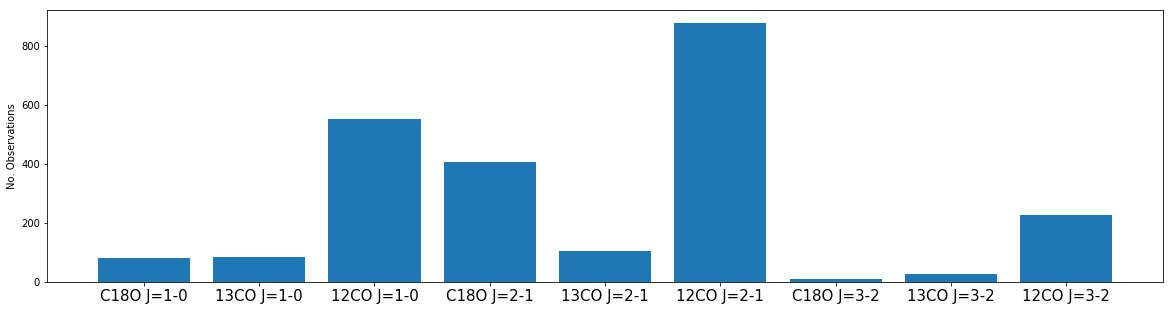

In [12]:
import numpy as np

performance = []
for line in line_names:
    line_observed = allSkyLinesQuery.queryResults['All sky'][line]
    performance.append(len(line_observed[line_observed==True]))

xpos = np.arange(len(performance))

plt.figure(figsize=(20,5))
plt.bar(xpos, performance)
plt.xticks(xpos, line_names, fontsize=15)
plt.ylabel('No. Observations')

### Group by NED source name

In [13]:
observations = allSkyLinesQuery.queryResults['All sky'].group_by('NED source name')

Iterate over the group sub-tables and corresponding keys with:

In [14]:
n = 0
for key, group in zip(observations.groups.keys, observations.groups):
    # if all three lines detected
    if ((True in group['12CO J=1-0']) & 
        (True in group['13CO J=1-0']) &
        (True in group['C18O J=1-0'])):
        
        print('****** {0} *******'.format(key['NED source name']))
        display(group)
        print('')
        n= n+1


****** 2MASX J17232194-0017009 *******


<Table masked=True length=6>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2017.1.01306.S   IRAS17208-0014  260.8414291666761 ...      False      False
2018.1.00486.S  IRAS_17208-0014  260.8414291699583 ...      False      False
2016.1.00140.S  IRASf17207-0014 260.84142916662347 ...      False      False
2015.1.00102.S IRAS_F17207-0014  260.8414292000252 ...       True       True
2016.1.00177.S IRAS_F17207-0014  260.8415999999851 ...      False      False
2017.1.00767.S IRAS_F17207-0014  260.8414291666889 ...      False      False


****** ARP 220 *******


<Table masked=True length=26>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.00736.S          Arp_220  233.7384331670012 ...      False       True
2015.1.00167.S           Arp220 233.73862916664658 ...      False      False
2017.1.00042.S           ARP220   233.738433333314 ...      False      False
2012.1.00453.S           Arp220  233.7386291666667 ...      False      False
2015.1.00113.S           ARP220  233.7384041666667 ...      False      False
2015.1.00113.S           ARP220 233.73840416669236 ...      False      False
2012.1.00453.S           Arp220  233.7386291666667 ...      False      False
2015.1.00113.S           ARP220 233.73840416669054 ...      False       True
2017.1.00042.S           ARP220  233.7384333332796 ...      False      False
           ...              ...                ... ...        ...        ...
2015.1.00113.S           ARP220 233.73840416669907 ...      False      False
2017.1.00042.S           ARP220 233.73843333337174 ...      False      False
2017.1.00042.S           ARP220  233.7384333333283 ...      False      False
2012.1.00453.S           Arp220  233.7386291666667 ...      False      False
2015.1.00167.S           Arp220 233.73862916663217 ...      False      False
2015.1.00113.S           ARP220  233.7384041666667 ...      False      False
2015.1.00113.S           ARP220  233.7384041666667 ...      False      False
2015.1.00113.S           ARP220 233.73840416671834 ...      False      False
2015.1.00113.S           ARP220  233.7384041666667 ...      False      False
2013.1.00099.S           Arp220       233.73843317 ...      False      False


****** IC 1623 *******


<Table masked=True length=12>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2011.0.00467.S            vv114            16.9467 ...      False      False
2011.0.00467.S            vv114            16.9467 ...      False      False
2013.1.00740.S            vv114 16.946700000000003 ...      False       True
2016.2.00042.S            vv114  16.94666666672407 ...      False      False
2016.2.00042.S            vv114  16.94666666670094 ...      False       True
2011.0.00467.S            vv114            16.9467 ...      False      False
2011.0.00467.S            vv114  16.94640869275988 ...       True       True
2013.1.00469.S            VV114            16.9467 ...      False      False
2013.1.00469.S            VV114 16.946350477037736 ...      False      False
2015.1.00003.S            vv114 16.946699999994845 ...      False      False
2013.1.01057.S            vv114            16.9467 ...      False      False
2011.0.00467.S            vv114            16.9467 ...      False      False


****** MESSIER 066 *******


<Table masked=True length=13>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.01538.S          NGC3627 170.06166194198218 ...      False      False
2013.1.00634.S         NGC_3627         170.062608 ...      False      False
2015.1.00956.S         NGC_3627  170.0640337201739 ...      False      False
2015.1.01538.S          NGC3627  170.0616617823787 ...      False      False
2015.1.00956.S         NGC_3627 170.06403352094807 ...      False      False
2015.1.00956.S         NGC_3627 170.06403352090246 ...      False      False
2015.1.00978.S         NGC_3627  170.0626082999933 ...      False      False
2015.1.00978.S         NGC_3627         170.062608 ...      False      False
2016.1.00972.S         NGC_3627 170.06260833000144 ...       True      False
2015.1.00956.S         NGC_3627 170.06403367235694 ...      False      False
2015.1.00956.S         NGC_3627 170.06260829996947 ...      False      False
2015.1.01538.S          NGC3627 170.06141532081972 ...      False      False
2015.1.00956.S         NGC_3627  170.0626082999792 ...      False      False


****** MESSIER 074 *******


<Table masked=True length=9>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2012.1.00650.S              M74  24.17210828828207 ...      False      False
2012.1.00650.S              M74 24.174050000000005 ...      False      False
2012.1.00650.S              M74 24.173305728064474 ...      False      False
2013.1.00532.S           ngc628 24.173673230208454 ...      False      False
2013.1.00532.S           ngc628 24.174050000000005 ...      False      False
2013.1.00532.S           ngc628  24.17404956513444 ...      False      False
2013.1.00532.S           ngc628 24.174049999999998 ...      False      False
2013.1.00532.S           ngc628 24.174050000000005 ...      False      False
2013.1.00532.S           ngc628 24.174050000000005 ...      False      False


****** MESSIER 077 *******


<Table masked=True length=21>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2018.1.01684.S          NGC1068  40.66962125002543 ...      False      False
2018.1.01684.S          NGC1068  40.66962125000868 ...      False      False
2011.0.00061.S         NGC 1068 40.668602777740276 ...       True      False
2011.0.00061.S         NGC 1068 40.669991666666675 ...      False      False
2012.1.00657.S         NGC_1068 40.669991666666675 ...      False      False
2016.1.00232.S          NGC1068  40.66987874994682 ...      False      False
2013.1.00221.S          NGC1068  40.66962416666667 ...      False      False
2017.1.01666.S          NGC1068  40.66962083331033 ...      False      False
2016.1.00232.S          NGC1068 40.669878749975425 ...      False       True
2013.1.01151.S          NGC1068 40.669583333333335 ...      False      False
2016.1.00232.S          NGC1068  40.66987874994658 ...      False      False
2018.1.01506.S          NGC1068 40.669879166617186 ...      False      False
2013.1.00060.S          NGC1068        40.66962125 ...      False      False
2018.1.01684.S          NGC1068 40.669621249974156 ...      False      False
2013.1.00111.S          ngc1068          40.669879 ...      False      False
2018.1.01684.S          NGC1068 40.669621249968124 ...      False      False
2013.1.00188.S         NGC_1068          40.669879 ...      False       True
2013.1.01307.S         ngc_1068          40.669879 ...      False       True
2013.1.00060.S          NGC1068        40.66962125 ...      False      False
2016.1.00232.S          NGC1068  40.66987874996256 ...      False       True
2011.0.00083.S          NGC1068  40.66987900000001 ...      False       True


****** MESSIER 083 *******


<Table masked=True length=70>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2013.1.01161.S              M83 204.25309338930765 ...      False      False
2012.1.00762.S              m83 204.26857525564225 ...      False      False
2015.1.01593.S              m83 204.27338641958724 ...      False       True
2017.1.00079.S              M83 204.24797765939616 ...      False      False
2017.1.00079.S              M83 204.24712522989824 ...      False      False
2015.1.00121.S              M83 204.27078749999995 ...      False      False
2017.1.00065.S              M83 204.27426250000713 ...      False       True
2016.1.00386.S              M83 204.21790635420905 ...      False      False
2016.1.00386.S              M83 204.31791115438452 ...      False      False
           ...              ...                ... ...        ...        ...
2016.1.00386.S              M83 204.21787673784144 ...      False      False
2016.1.00386.S              M83   204.231205455925 ...      False      False
2016.1.00386.S              M83 204.28834166665396 ...      False      False
2011.0.00772.S              M83 204.26984488706844 ...      False      False
2017.1.00079.S              M83 204.29964301727202 ...      False      False
2016.1.00386.S              M83  204.2750471157561 ...      False      False
2017.1.00079.S              M83  204.1964332471303 ...      False      False
2015.1.00121.S              M83 204.25312301700413 ...      False      False
2016.1.00386.S              M83 204.28831004077819 ...      False      False
2016.1.00164.S              M83 204.25312500002616 ...      False      False


****** MESSIER 095 *******


<Table masked=True length=9>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.00956.S         NGC_3351 160.99055420000045 ...      False      False
2016.2.00053.S          NGC3351 160.99055416665422 ...      False      False
2015.1.00956.S         NGC_3351 160.99055419999996 ...      False      False
2013.1.00634.S         NGC_3351         160.990554 ...      False      False
2013.1.00885.S         NGC_3351         160.990554 ...      False      False
2013.1.00493.S          NGC3351         160.990554 ...      False       True
2013.1.00885.S         NGC_3351 160.99055400000003 ...      False      False
2015.1.00956.S         NGC_3351 160.99055420000133 ...      False      False
2016.1.00972.S         NGC_3351 160.99055417000724 ...       True      False


****** MESSIER 100 *******


<Table masked=True length=16>
  Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                        deg         ...                      
    bytes64         bytes256          float64       ...    bool       bool   
--------------- ---------------- ------------------ ... ---------- ----------
2011.0.00004.SV             M100  185.7256935716741 ...      False      False
2011.0.00004.SV             M100 185.72641646606877 ...      False      False
2011.0.00004.SV             M100 185.72641646606877 ...      False      False
2011.0.00004.SV             M100  185.7264164660687 ...      False      False
2011.0.00004.SV             M100 185.72730240368034 ...      False      False
 2015.1.00978.S         NGC_4321 185.72874580004427 ...      False      False
 2013.1.00634.S         NGC_4321         185.728746 ...      False      False
 2015.1.00956.S         NGC_4321 185.72874580001331 ...      False      False
 2015.1.00956.S         NGC_4321  185.7287458000029 ...      False      False
 2015.1.00956.S         NGC_4321 185.72585881043787 ...      False      False
 2015.1.00978.S         NGC_4321  185.7287460000163 ...      False      False
 2015.1.00956.S         NGC_4321 185.72585845342252 ...      False      False
 2016.1.00972.S         NGC_4321  185.7287458299451 ...      False      False
 2015.1.00956.S         NGC_4321    185.72585845348 ...      False      False
 2015.1.00956.S         NGC_4321 185.72585881041607 ...      False      False
 2016.1.00972.S         NGC_4321   185.728745830017 ...       True      False


****** MRK 0926 *******


<Table masked=True length=4>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2016.1.00952.S      HE2302-0857 346.18121291671105 ...      False      False
2016.1.00952.S      HE2302-0857  346.1812129166361 ...      False      False
2018.1.00576.S          Mrk_926   346.181244000029 ...      False      False
2018.1.00576.S          Mrk_926 346.18124399994156 ...      False      False


****** NGC 0055 *******


<Table masked=True length=11>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2012.1.00335.S              N55  83.06456651508347 ...      False      False
2013.1.00214.S              N55  83.06512741389821 ...      False      False
2013.1.00214.S              N55  83.06456666630032 ...      False      False
2012.1.00335.S              N55  83.06512726273334 ...      False      False
2016.1.00772.S           NGC_55  3.948011831158616 ...      False      False
2016.1.00772.S           NGC_55 3.7233333333104404 ...      False      False
2016.1.00772.S           NGC_55  3.583691449005201 ...      False      False
2016.1.00772.S           NGC_55 3.7233333332840366 ...      False      False
2016.1.00772.S           NGC_55 3.7368472686501777 ...      False      False
2015.1.00944.S           NGC_55 3.7516666666482106 ...      False      False
2016.1.00772.S           NGC_55 3.7233333333483603 ...      False      False


****** NGC 0253 *******


<Table masked=True length=58>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2017.1.00161.L           ngc253 11.888425518714275 ...      False      False
2017.1.00433.S           NGC253  11.88767170339583 ...      False       True
2012.1.00789.S          ngc_253 11.888208333333331 ...      False      False
2018.1.00294.S           NGC253 11.887778763002808 ...       True      False
2015.1.00274.S           NGC253 11.887447533330743 ...      False       True
2017.1.00161.L           ngc253 11.888429049356906 ...      False      False
2016.1.00292.S           NGC253 11.888258333381177 ...      False      False
2016.1.00481.S          NGC_253 11.887896249983545 ...      False      False
2018.1.01321.S          NGC_253 11.887499999948993 ...      False      False
           ...              ...                ... ...        ...        ...
2012.1.00789.S          ngc_253 11.888208333333333 ...      False      False
2013.1.00099.S           NGC253          11.888058 ...      False      False
2015.1.00274.S           NGC253 11.887447916639449 ...      False       True
2016.1.00215.S           ngc253  11.90096108450304 ...      False      False
2016.1.00481.S          NGC_253 11.887896250046005 ...      False      False
2012.1.00108.S           NGC253 11.888122697386494 ...      False      False
2013.1.00099.S           NGC253          11.888058 ...      False      False
2015.1.00274.S           NGC253 11.888058299992112 ...      False       True
2011.0.00172.S           NGC253 11.888107252970965 ...      False      False
2017.1.00161.L           ngc253 11.888672770259024 ...      False      False


****** NGC 0613 *******


<Table masked=True length=12>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2013.1.01329.S             n613 23.575978999999997 ...      False       True
2013.1.01329.S             n613          23.575979 ...      False       True
2015.1.01487.S             n613 23.575979199958084 ...      False      False
2013.1.01329.S             n613 23.575978999999997 ...      False       True
2015.1.01487.S             n613  23.57597919995453 ...      False      False
2017.1.01671.S           NGC613 23.575791666643994 ...      False      False
2016.1.00296.S          NGC_613 23.575979169959492 ...      False       True
2016.1.00296.S          NGC_613 23.575979170013174 ...      False       True
2017.1.00236.S          ngc_613 23.575979166673825 ...      False      False
2017.1.01671.S           NGC613   23.5757916666323 ...      False      False
2015.1.00404.S          NGC_613 23.575979200001644 ...      False       True
2015.1.00404.S          NGC_613 23.575979199951142 ...      False       True


****** NGC 1097 *******


<Table masked=True length=14>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2017.1.00886.L          NGC1097  41.56755604279475 ...      False      False
2012.1.00001.S          NGC1097 41.568117251631406 ...      False      False
2012.1.00001.S          NGC1097  41.58102057398962 ...      False      False
2012.1.00001.S          NGC1097 41.581022260490315 ...      False      False
2012.1.00001.S          NGC1097  41.58102229141906 ...      False      False
2017.1.00886.L          NGC1097  41.57955169996654 ...      False      False
2015.1.00126.S          NGC1097 41.579412499999904 ...      False       True
2017.1.00886.L          NGC1097 41.567750996985055 ...      False      False
2017.1.00886.L          NGC1097  41.57955169997293 ...      False      False
2017.1.00886.L          NGC1097  41.59174579680493 ...      False      False
2012.1.00001.S          NGC1097          41.579412 ...      False      False
2017.1.00886.L          NGC1097  41.59155078378735 ...      False      False
2011.0.00108.S          NGC1097          41.579412 ...      False       True
2012.1.00187.S         NGC_1097           41.57905 ...      False       True


****** NGC 1614 *******


<Table masked=True length=14>
 Project code  ALMA source name      ALMA RA      ... 13CO J=3-2 12CO J=3-2
                                       deg        ...                      
   bytes64         bytes256          float64      ...    bool       bool   
-------------- ---------------- ----------------- ... ---------- ----------
2011.0.00768.S          NGC1614         68.500112 ...      False       True
2013.1.01172.S         ngc_1614 68.50020404482204 ...      False      False
2013.1.01172.S         ngc_1614 68.50020404482204 ...      False      False
2013.1.00991.S         NGC_1614         68.500112 ...      False      False
2013.1.01172.S         ngc_1614 68.50020404482204 ...      False      False
2013.1.00991.S         NGC_1614         68.500112 ...      False      False
2013.1.01172.S         ngc_1614 68.50020404482204 ...      False      False
2013.1.00991.S         NGC_1614         68.500112 ...      False      False
2017.1.00255.S          ngc1614 68.50011250005517 ...      False      False
2013.1.00814.S          NGC1614 68.50006041666667 ...      False       True
2013.1.00991.S         NGC_1614         68.500112 ...      False      False
2017.1.00255.S          ngc1614 68.50011250005363 ...      False      False
2013.1.00991.S         NGC_1614         68.500112 ...      False      False
2013.1.00991.S         NGC_1614         68.500112 ...      False      False


****** NGC 2623 *******


<Table masked=True length=4>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.01191.S          NGC2623 129.60038750001488 ...      False      False
2015.1.00804.S         NGC_2623         129.600387 ...      False      False
2017.1.01306.S          NGC2623  129.6003874999838 ...      False      False
2015.1.00804.S         NGC_2623         129.600387 ...      False      False


****** NGC 3110 *******


<Table masked=True length=6>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2017.1.00255.S          ngc3110 151.00885000001242 ...      False      False
2017.1.00255.S          ngc3110 151.00884999995534 ...      False      False
2013.1.01172.S         ngc_3110 151.00865280123847 ...      False      False
2013.1.01172.S         ngc_3110 151.00865280123847 ...      False      False
2013.1.01172.S         ngc_3110 151.00865280123926 ...      False      False
2013.1.01172.S         ngc_3110  151.0086528012392 ...      False      False


****** NGC 3256 *******


<Table masked=True length=29>
  Project code   ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                         deg         ...                      
    bytes64          bytes256          float64       ...    bool       bool   
---------------- ---------------- ------------------ ... ---------- ----------
  2015.1.00714.S         NGC_3256 156.96340772103753 ...      False      False
  2015.1.00412.S         ngc_3256 156.96345833331614 ...      False      False
  2016.2.00094.S          NGC3256  156.9634583333204 ...      False      False
  2018.1.00223.S          NGC3256  156.9634583333501 ...      False      False
  2015.1.00714.S         NGC_3256 156.96499999999997 ...      False      False
  2018.1.00223.S          NGC3256 156.96345833331324 ...      False       True
  2011.0.00525.S          NGC3256 156.96345833333334 ...      False      False
  2016.2.00042.S          ngc3256  156.9649999999747 ...      False      False
  2018.1.00223.S          NGC3256 156.96345833332305 ...      False      False
             ...              ...                ... ...        ...        ...
 2011.0.00002.SV          NGC3256            156.965 ...      False      False
9999.4.99006.SIM          NGC3256            156.965 ...      False      False
  2015.1.00412.S         ngc_3256  156.9634583333206 ...      False      False
  2018.1.00223.S          NGC3256 156.96345833339134 ...      False      False
  2015.1.00993.S          ngc3256 156.96345833333334 ...      False      False
  2016.2.00094.S         ngc_3256 156.96499999997556 ...      False      False
  2016.2.00094.S          NGC3256 156.96345833331944 ...      False       True
  2016.2.00042.S          ngc3256  156.9649999999983 ...      False       True
  2015.1.00714.S         NGC_3256 156.96278395661244 ...      False      False
  2015.1.00412.S         NGC_3256 156.96345833332293 ...      False      False


****** NGC 4355 *******


<Table masked=True length=9>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2012.1.00377.S          NGC4418          186.72755 ...      False      False
2016.1.00382.S          ngc4418 186.72754999998762 ...      False      False
2016.1.00387.S          NGC4418 186.72755000003175 ...      False      False
2012.1.00377.S          NGC4418 186.72755000000004 ...      False      False
2012.1.00377.S          NGC4418 186.72755000000004 ...      False      False
2011.0.00820.S          ngc4418         186.727617 ...      False      False
2011.0.00820.S          ngc4418         186.727617 ...      False      False
2015.1.00042.S         NGC_4418 186.72755000003286 ...      False       True
2016.1.00177.S         NGC_4418 186.72769999996177 ...      False      False


****** NGC 4522 *******


<Table masked=True length=3>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.01341.S          ngc4522 188.40862512540662 ...      False      False
2015.1.01341.S          ngc4522   188.408625254809 ...      False      False
2015.1.01341.S          ngc4522 188.40862512540662 ...      False      False


****** NGC 4526 *******


<Table masked=True length=2>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2017.1.01108.S          ngc4526 188.51262083333418 ...      False      False
2018.1.01599.S         NGC_4526 188.51262083331764 ...      False      False


****** NGC 4945 *******


<Table masked=True length=15>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2017.1.00002.S          ngc4945 196.36366249998383 ...      False      False
2016.1.01135.S          ngc4945 196.36366250005398 ...      False       True
2018.1.00986.S          NGC4945 196.36366249997195 ...      False      False
2013.1.00099.S          NGC4945         196.363663 ...      False      False
2012.1.00332.S         NGC_4945 196.36458333333334 ...      False       True
2018.1.00986.S          NGC4945  196.3636624999718 ...      False      False
2013.1.00099.S          NGC4945         196.363663 ...      False      False
2013.1.01151.S          NGC4945 196.36458333333334 ...      False      False
2018.1.01236.S          NGC4945 196.36448317497292 ...      False       True
2016.2.00098.S          NGC4945  196.3608702621777 ...      False      False
2016.1.01279.S          NGC4945 196.36174784975034 ...      False      False
2013.1.00099.S          NGC4945         196.363663 ...      False      False
2018.1.01236.S          NGC4945 196.36366249999054 ...      False       True
2018.1.01236.S          NGC4945 196.36448317498895 ...      False       True
2017.1.00002.S          ngc4945  196.3636624999866 ...      False      False


****** NGC 5128 *******


<Table masked=True length=31>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2011.0.00010.S             CenA         201.365063 ...      False      False
2011.0.00010.S             CenA         201.365063 ...      False      False
2013.1.00803.S      Centaurus_A       201.36506279 ...      False      False
2013.1.00803.S      Centaurus_A       201.36506279 ...      False      False
2017.1.00005.S      Centaurus_A 201.36506279001526 ...      False      False
2012.1.00225.S      Centaurus_a 201.36519072617517 ...      False       True
2017.1.01162.S      Centaurus_a 201.36506278998147 ...      False       True
2013.1.00803.S      Centaurus_A 201.36497532054403 ...      False      False
2013.1.00803.S      Centaurus_A  201.3650645292383 ...      False      False
           ...              ...                ... ...        ...        ...
2015.1.00483.S      Centaurus_A 201.36772229288474 ...      False       True
2013.1.00803.S      Centaurus_A 201.36506694626658 ...      False      False
2013.1.00803.S      Centaurus_A  201.3650656459087 ...      False      False
2013.1.00803.S      Centaurus_A   201.365064337408 ...      False      False
2012.1.00019.S      Centaurus_A 201.36506452923828 ...      False      False
2015.1.00483.S      Centaurus_A 201.36734237833147 ...      False      False
2015.1.01577.S      Centaurus_A 201.36510575736133 ...      False      False
2013.1.00803.S      Centaurus_A 201.36509458913827 ...      False      False
2015.1.00483.S      Centaurus_A 201.36506279005116 ...      False       True
2013.1.00803.S      Centaurus_A 201.36510575780628 ...      False      False


****** NGC 5257 *******


<Table masked=True length=6>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.00804.S         NGC_5257 204.96948566791136 ...      False      False
2015.1.00804.S         NGC_5257 204.97050800002276 ...      False      False
2015.1.00804.S         NGC_5257  204.9705079999447 ...      False      False
2015.1.00804.S         NGC_5257 204.97050800000002 ...      False      False
2015.1.00804.S         NGC_5257 204.97029964465267 ...      False      False
2015.1.00804.S         NGC_5257 204.97050799997672 ...      False      False


****** NGC 5258 *******


<Table masked=True length=7>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.00804.S          NGC5258        204.9903125 ...      False      False
2015.1.00804.S         NGC_5258  204.9903125000263 ...      False      False
2015.1.00804.S         NGC_5258  204.9903124999453 ...      False      False
2015.1.00804.S         NGC_5258  204.9903125000193 ...      False      False
2015.1.00804.S         NGC_5258 204.99087723871202 ...      False      False
2015.1.00804.S          NGC5258 204.99031249997842 ...      False      False
2015.1.00804.S         NGC_5258 204.99134594228696 ...      False      False


****** NGC 6240 *******


<Table masked=True length=13>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.00003.S          ngc6240 253.24525399994147 ...      False      False
2015.1.00003.S          ngc6240 253.24525400004578 ...      False      False
2015.1.00370.S         NGC_6240 253.24559136686986 ...      False      False
2015.1.00370.S         NGC_6240 253.24525420002288 ...      False      False
2015.1.00370.S         NGC_6240        253.2452542 ...      False      False
2013.1.00813.S         NGC_6240         253.245254 ...      False       True
2015.1.00003.S          ngc6240 253.24525399996847 ...      False      False
2016.2.00042.S          ngc6240  253.2452541666758 ...      False      False
2013.1.00049.S         NGC_6240 253.24525416666663 ...      False      False
2015.1.01439.S          ngc6240 253.24525420002365 ...      False      False
2016.2.00042.S          ngc6240 253.24525416666927 ...      False       True
2013.1.00813.S         NGC_6240         253.245254 ...      False       True
2017.1.01158.S            VV617 253.24519400774125 ...      False      False


****** NGC 7465 *******


<Table masked=True length=7>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2018.1.01599.S         NGC_7465  345.5039666666451 ...      False      False
2016.1.01119.S         NGC_7465  345.5039666699488 ...      False      False
2015.1.00989.S         ngc_7465 345.50396669995143 ...      False      False
2018.1.00113.S          NGC7465  345.5039666667015 ...      False       True
2016.1.01119.S         NGC_7465 345.50396666996454 ...      False      False
2018.1.00113.S          NGC7465 345.50396666661766 ...      False       True
2018.1.01253.S          ngc7465  345.5039666666712 ...      False      False


****** NGC 7469 *******


<Table masked=True length=12>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2017.1.00395.S  IRASF23007+0836 345.81514579090805 ...      False      False
2012.1.00165.S          NGC7469  345.8151666666666 ...      False       True
2013.1.00218.S          NGC7469  345.8151666666666 ...      False      False
2017.1.00078.S          NGC7469  345.8153083333856 ...      False      False
2017.1.00078.S          NGC7469 345.81530833333125 ...      False       True
2017.1.00078.S          NGC7469  345.8153083333014 ...      False      False
2017.1.00078.S          NGC7469 345.81530833333335 ...      False      False
2017.1.00078.S          NGC7469  345.8153083333354 ...      False       True
2017.1.00078.S          NGC7469  345.8153083333159 ...      False      False
2013.1.00218.S          NGC7469  345.8151666666666 ...      False      False
2017.1.00078.S          NGC7469 345.81530833330066 ...      False      False
2017.1.00078.S          NGC7469 345.81530833334466 ...      False      False


****** WKK 2031 *******


<Table masked=True length=13>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2018.1.00503.S  IRAS_13120-5453 198.77653107265738 ...      False      False
2017.1.00395.S   IRAS13120-5453 198.77650299255595 ...      False      False
2015.1.00102.S  IRAS_13120-5453 198.77644875002113 ...       True       True
2015.1.00287.S  IRAS_13120-5453 198.77642458328958 ...      False      False
2016.2.00042.S   iras13120-5453 198.77644874998612 ...      False       True
2015.1.00287.S  IRAS_13120-5453 198.77642458330507 ...      False      False
2015.1.00287.S  IRAS_13120-5453  198.7764245833313 ...      False      False
2013.1.00379.S  IRAS_13120-5453 198.77642458333332 ...      False       True
2013.1.00379.S  IRAS_13120-5453 198.77642458333332 ...      False      False
2016.1.00777.S  IRAS_13120-5453 198.77640416670855 ...       True      False
2015.1.00287.S  IRAS_13120-5453 198.77642458330794 ...      False      False
2016.1.00777.S  IRAS_13120-5453 198.77640416664184 ...      False      False
2012.1.00306.S   IRAS13120-5453  198.7758333333333 ...      False      False

In [15]:
print("There are ", n, "galaxies in the target redshift range with 12CO, 13CO, AND C18O observations.")

There are  29 galaxies in the target redshift range with 12CO, 13CO, AND C18O observations.


In [16]:
k = 0
target_names = []
target_idx = []
target_table = []
for i, (key, group) in enumerate(zip(observations.groups.keys, observations.groups)):
    # if all three lines detected
    if ((True in group['13CO J=1-0']) & (True in group['C18O J=1-0']) or
        (True in group['13CO J=2-1']) & (True in group['C18O J=2-1']) or
        (True in group['13CO J=3-2']) & (True in group['C18O J=3-2'])):
        
        print('****** {0} *******'.format(key['NED source name']))
        display(group)
        print('')
        target_names.append(key['NED source name'])
        target_idx.append(i)
        target_table.append(group)
        k= k+1

****** 2MASS J16424012-0943133 *******


<Table masked=True length=2>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2013.1.00877.S  IRASF16399-0937 250.66666666666669 ...      False       True
2015.1.01439.S IRAS_F16399-0937  250.6674500000451 ...      False      False


****** 2MASX J17232194-0017009 *******


<Table masked=True length=6>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2017.1.01306.S   IRAS17208-0014  260.8414291666761 ...      False      False
2018.1.00486.S  IRAS_17208-0014  260.8414291699583 ...      False      False
2016.1.00140.S  IRASf17207-0014 260.84142916662347 ...      False      False
2015.1.00102.S IRAS_F17207-0014  260.8414292000252 ...       True       True
2016.1.00177.S IRAS_F17207-0014  260.8415999999851 ...      False      False
2017.1.00767.S IRAS_F17207-0014  260.8414291666889 ...      False      False


****** ARP 220 *******


<Table masked=True length=26>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.00736.S          Arp_220  233.7384331670012 ...      False       True
2015.1.00167.S           Arp220 233.73862916664658 ...      False      False
2017.1.00042.S           ARP220   233.738433333314 ...      False      False
2012.1.00453.S           Arp220  233.7386291666667 ...      False      False
2015.1.00113.S           ARP220  233.7384041666667 ...      False      False
2015.1.00113.S           ARP220 233.73840416669236 ...      False      False
2012.1.00453.S           Arp220  233.7386291666667 ...      False      False
2015.1.00113.S           ARP220 233.73840416669054 ...      False       True
2017.1.00042.S           ARP220  233.7384333332796 ...      False      False
           ...              ...                ... ...        ...        ...
2015.1.00113.S           ARP220 233.73840416669907 ...      False      False
2017.1.00042.S           ARP220 233.73843333337174 ...      False      False
2017.1.00042.S           ARP220  233.7384333333283 ...      False      False
2012.1.00453.S           Arp220  233.7386291666667 ...      False      False
2015.1.00167.S           Arp220 233.73862916663217 ...      False      False
2015.1.00113.S           ARP220  233.7384041666667 ...      False      False
2015.1.00113.S           ARP220  233.7384041666667 ...      False      False
2015.1.00113.S           ARP220 233.73840416671834 ...      False      False
2015.1.00113.S           ARP220  233.7384041666667 ...      False      False
2013.1.00099.S           Arp220       233.73843317 ...      False      False


****** ARP 244 *******


<Table masked=True length=9>
  Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                        deg         ...                      
    bytes64         bytes256          float64       ...    bool       bool   
--------------- ---------------- ------------------ ... ---------- ----------
 2016.1.00924.S         Antennae 180.47802333333243 ...      False      False
 2016.1.00924.S         Antennae  180.4780233332819 ...      False      False
2011.0.00003.SV         Antennae  180.4750648105457 ...      False       True
 2015.1.00038.S         Antennae 180.47874999996384 ...       True       True
 2016.1.00924.S         Antennae 180.47802333333186 ...      False       True
 2015.1.00977.S         Antennae 180.47802360367766 ...      False      False
 2016.1.00924.S         Antennae  180.4780233333896 ...      False       True
 2016.1.00924.S         Antennae  180.4780233333657 ...      False      False
 2016.1.00924.S         Antennae 180.47802333333118 ...      False      False


****** DL Tau *******


<Table masked=True length=1>
 Project code  ALMA source name      ALMA RA      ... 13CO J=3-2 12CO J=3-2
                                       deg        ...                      
   bytes64         bytes256          float64      ...    bool       bool   
-------------- ---------------- ----------------- ... ---------- ----------
2016.1.01164.S           DL_Tau 68.41279793938965 ...      False      False


****** ESO 350-IG 038 *******


<Table masked=True length=5>
 Project code  ALMA source name      ALMA RA      ... 13CO J=3-2 12CO J=3-2
                                       deg        ...                      
   bytes64         bytes256          float64      ...    bool       bool   
-------------- ---------------- ----------------- ... ---------- ----------
2015.1.00586.S           haro11 9.218749999965967 ...      False      False
2015.1.00586.S           haro11 9.218750000025214 ...      False      False
2013.1.00350.S           Haro11           9.21875 ...      False      False
2013.1.00350.S           Haro11           9.21875 ...      False      False
2013.1.00350.S           Haro11           9.21875 ...      False      False


****** IC 0860 *******


<Table masked=True length=1>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2016.1.00800.S            IC860 198.76461999999253 ...      False      False


****** IC 1623 *******


<Table masked=True length=12>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2011.0.00467.S            vv114            16.9467 ...      False      False
2011.0.00467.S            vv114            16.9467 ...      False      False
2013.1.00740.S            vv114 16.946700000000003 ...      False       True
2016.2.00042.S            vv114  16.94666666672407 ...      False      False
2016.2.00042.S            vv114  16.94666666670094 ...      False       True
2011.0.00467.S            vv114            16.9467 ...      False      False
2011.0.00467.S            vv114  16.94640869275988 ...       True       True
2013.1.00469.S            VV114            16.9467 ...      False      False
2013.1.00469.S            VV114 16.946350477037736 ...      False      False
2015.1.00003.S            vv114 16.946699999994845 ...      False      False
2013.1.01057.S            vv114            16.9467 ...      False      False
2011.0.00467.S            vv114            16.9467 ...      False      False


****** IC 5063 *******


<Table masked=True length=8>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.00420.S           IC5063 313.00970419995065 ...      False      False
2012.1.00435.S           IC5063 313.00970400000006 ...      False      False
2015.1.00467.S           ic5063 313.00970416668304 ...      False      False
2015.1.00467.S           ic5063   313.009704166653 ...      False       True
2015.1.00467.S           ic5063 313.00970416667195 ...      False      False
2015.1.00420.S           IC5063 313.00970420004825 ...      False      False
2015.1.00420.S           IC5063  313.0097041999772 ...      False       True
2016.1.01279.S           IC5063  313.0072453207015 ...      False      False


****** MESSIER 066 *******


<Table masked=True length=13>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.01538.S          NGC3627 170.06166194198218 ...      False      False
2013.1.00634.S         NGC_3627         170.062608 ...      False      False
2015.1.00956.S         NGC_3627  170.0640337201739 ...      False      False
2015.1.01538.S          NGC3627  170.0616617823787 ...      False      False
2015.1.00956.S         NGC_3627 170.06403352094807 ...      False      False
2015.1.00956.S         NGC_3627 170.06403352090246 ...      False      False
2015.1.00978.S         NGC_3627  170.0626082999933 ...      False      False
2015.1.00978.S         NGC_3627         170.062608 ...      False      False
2016.1.00972.S         NGC_3627 170.06260833000144 ...       True      False
2015.1.00956.S         NGC_3627 170.06403367235694 ...      False      False
2015.1.00956.S         NGC_3627 170.06260829996947 ...      False      False
2015.1.01538.S          NGC3627 170.06141532081972 ...      False      False
2015.1.00956.S         NGC_3627  170.0626082999792 ...      False      False


****** MESSIER 074 *******


<Table masked=True length=9>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2012.1.00650.S              M74  24.17210828828207 ...      False      False
2012.1.00650.S              M74 24.174050000000005 ...      False      False
2012.1.00650.S              M74 24.173305728064474 ...      False      False
2013.1.00532.S           ngc628 24.173673230208454 ...      False      False
2013.1.00532.S           ngc628 24.174050000000005 ...      False      False
2013.1.00532.S           ngc628  24.17404956513444 ...      False      False
2013.1.00532.S           ngc628 24.174049999999998 ...      False      False
2013.1.00532.S           ngc628 24.174050000000005 ...      False      False
2013.1.00532.S           ngc628 24.174050000000005 ...      False      False


****** MESSIER 077 *******


<Table masked=True length=21>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2018.1.01684.S          NGC1068  40.66962125002543 ...      False      False
2018.1.01684.S          NGC1068  40.66962125000868 ...      False      False
2011.0.00061.S         NGC 1068 40.668602777740276 ...       True      False
2011.0.00061.S         NGC 1068 40.669991666666675 ...      False      False
2012.1.00657.S         NGC_1068 40.669991666666675 ...      False      False
2016.1.00232.S          NGC1068  40.66987874994682 ...      False      False
2013.1.00221.S          NGC1068  40.66962416666667 ...      False      False
2017.1.01666.S          NGC1068  40.66962083331033 ...      False      False
2016.1.00232.S          NGC1068 40.669878749975425 ...      False       True
2013.1.01151.S          NGC1068 40.669583333333335 ...      False      False
2016.1.00232.S          NGC1068  40.66987874994658 ...      False      False
2018.1.01506.S          NGC1068 40.669879166617186 ...      False      False
2013.1.00060.S          NGC1068        40.66962125 ...      False      False
2018.1.01684.S          NGC1068 40.669621249974156 ...      False      False
2013.1.00111.S          ngc1068          40.669879 ...      False      False
2018.1.01684.S          NGC1068 40.669621249968124 ...      False      False
2013.1.00188.S         NGC_1068          40.669879 ...      False       True
2013.1.01307.S         ngc_1068          40.669879 ...      False       True
2013.1.00060.S          NGC1068        40.66962125 ...      False      False
2016.1.00232.S          NGC1068  40.66987874996256 ...      False       True
2011.0.00083.S          NGC1068  40.66987900000001 ...      False       True


****** MESSIER 083 *******


<Table masked=True length=70>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2013.1.01161.S              M83 204.25309338930765 ...      False      False
2012.1.00762.S              m83 204.26857525564225 ...      False      False
2015.1.01593.S              m83 204.27338641958724 ...      False       True
2017.1.00079.S              M83 204.24797765939616 ...      False      False
2017.1.00079.S              M83 204.24712522989824 ...      False      False
2015.1.00121.S              M83 204.27078749999995 ...      False      False
2017.1.00065.S              M83 204.27426250000713 ...      False       True
2016.1.00386.S              M83 204.21790635420905 ...      False      False
2016.1.00386.S              M83 204.31791115438452 ...      False      False
           ...              ...                ... ...        ...        ...
2016.1.00386.S              M83 204.21787673784144 ...      False      False
2016.1.00386.S              M83   204.231205455925 ...      False      False
2016.1.00386.S              M83 204.28834166665396 ...      False      False
2011.0.00772.S              M83 204.26984488706844 ...      False      False
2017.1.00079.S              M83 204.29964301727202 ...      False      False
2016.1.00386.S              M83  204.2750471157561 ...      False      False
2017.1.00079.S              M83  204.1964332471303 ...      False      False
2015.1.00121.S              M83 204.25312301700413 ...      False      False
2016.1.00386.S              M83 204.28831004077819 ...      False      False
2016.1.00164.S              M83 204.25312500002616 ...      False      False


****** MESSIER 095 *******


<Table masked=True length=9>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.00956.S         NGC_3351 160.99055420000045 ...      False      False
2016.2.00053.S          NGC3351 160.99055416665422 ...      False      False
2015.1.00956.S         NGC_3351 160.99055419999996 ...      False      False
2013.1.00634.S         NGC_3351         160.990554 ...      False      False
2013.1.00885.S         NGC_3351         160.990554 ...      False      False
2013.1.00493.S          NGC3351         160.990554 ...      False       True
2013.1.00885.S         NGC_3351 160.99055400000003 ...      False      False
2015.1.00956.S         NGC_3351 160.99055420000133 ...      False      False
2016.1.00972.S         NGC_3351 160.99055417000724 ...       True      False


****** MESSIER 099 *******


<Table masked=True length=7>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.00956.S         NGC_4254 184.71250747942187 ...      False      False
2015.1.00956.S         NGC_4254 184.71250747939277 ...      False      False
2015.1.00956.S         NGC_4254 184.71250676447727 ...      False      False
2013.1.00634.S         NGC_4254 184.70677099999997 ...      False      False
2015.1.00956.S         NGC_4254 184.71250676447025 ...      False      False
2015.1.00956.S         NGC_4254 184.70677080002537 ...      False      False
2015.1.00956.S         NGC_4254 184.70677080003017 ...      False      False


****** MESSIER 100 *******


<Table masked=True length=16>
  Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                        deg         ...                      
    bytes64         bytes256          float64       ...    bool       bool   
--------------- ---------------- ------------------ ... ---------- ----------
2011.0.00004.SV             M100  185.7256935716741 ...      False      False
2011.0.00004.SV             M100 185.72641646606877 ...      False      False
2011.0.00004.SV             M100 185.72641646606877 ...      False      False
2011.0.00004.SV             M100  185.7264164660687 ...      False      False
2011.0.00004.SV             M100 185.72730240368034 ...      False      False
 2015.1.00978.S         NGC_4321 185.72874580004427 ...      False      False
 2013.1.00634.S         NGC_4321         185.728746 ...      False      False
 2015.1.00956.S         NGC_4321 185.72874580001331 ...      False      False
 2015.1.00956.S         NGC_4321  185.7287458000029 ...      False      False
 2015.1.00956.S         NGC_4321 185.72585881043787 ...      False      False
 2015.1.00978.S         NGC_4321  185.7287460000163 ...      False      False
 2015.1.00956.S         NGC_4321 185.72585845342252 ...      False      False
 2016.1.00972.S         NGC_4321  185.7287458299451 ...      False      False
 2015.1.00956.S         NGC_4321    185.72585845348 ...      False      False
 2015.1.00956.S         NGC_4321 185.72585881041607 ...      False      False
 2016.1.00972.S         NGC_4321   185.728745830017 ...       True      False


****** MRK 0926 *******


<Table masked=True length=4>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2016.1.00952.S      HE2302-0857 346.18121291671105 ...      False      False
2016.1.00952.S      HE2302-0857  346.1812129166361 ...      False      False
2018.1.00576.S          Mrk_926   346.181244000029 ...      False      False
2018.1.00576.S          Mrk_926 346.18124399994156 ...      False      False


****** NGC 0017 *******


<Table masked=True length=3>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2016.2.00046.S          NGC0017   2.77754999995307 ...      False      False
2013.1.00814.S          NGC0034 2.7772666666666668 ...      False       True
2016.1.00323.S           NGC_34 2.7772375000124554 ...       True      False


****** NGC 0055 *******


<Table masked=True length=11>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2012.1.00335.S              N55  83.06456651508347 ...      False      False
2013.1.00214.S              N55  83.06512741389821 ...      False      False
2013.1.00214.S              N55  83.06456666630032 ...      False      False
2012.1.00335.S              N55  83.06512726273334 ...      False      False
2016.1.00772.S           NGC_55  3.948011831158616 ...      False      False
2016.1.00772.S           NGC_55 3.7233333333104404 ...      False      False
2016.1.00772.S           NGC_55  3.583691449005201 ...      False      False
2016.1.00772.S           NGC_55 3.7233333332840366 ...      False      False
2016.1.00772.S           NGC_55 3.7368472686501777 ...      False      False
2015.1.00944.S           NGC_55 3.7516666666482106 ...      False      False
2016.1.00772.S           NGC_55 3.7233333333483603 ...      False      False


****** NGC 0113 *******


<Table masked=True length=3>
 Project code  ALMA source name      ALMA RA      ... 13CO J=3-2 12CO J=3-2
                                       deg        ...                      
   bytes64         bytes256          float64      ...    bool       bool   
-------------- ---------------- ----------------- ... ---------- ----------
2015.1.01388.S             N113 78.34182864786013 ...      False      False
2015.1.01388.S             N113 78.33693706985134 ...      False      False
2013.1.01136.S             N113 78.32583333333334 ...      False      False


****** NGC 0171 *******


<Table masked=True length=3>
 Project code  ALMA source name      ALMA RA      ... 13CO J=3-2 12CO J=3-2
                                       deg        ...                      
   bytes64         bytes256          float64      ...    bool       bool   
-------------- ---------------- ----------------- ... ---------- ----------
2016.1.00203.S             N171 84.94482499998678 ...      False      False
2016.1.00203.S             N171 84.94482500005665 ...      False      False
2016.1.00203.S             N171 84.94482500003063 ...      False      False


****** NGC 0253 *******


<Table masked=True length=58>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2017.1.00161.L           ngc253 11.888425518714275 ...      False      False
2017.1.00433.S           NGC253  11.88767170339583 ...      False       True
2012.1.00789.S          ngc_253 11.888208333333331 ...      False      False
2018.1.00294.S           NGC253 11.887778763002808 ...       True      False
2015.1.00274.S           NGC253 11.887447533330743 ...      False       True
2017.1.00161.L           ngc253 11.888429049356906 ...      False      False
2016.1.00292.S           NGC253 11.888258333381177 ...      False      False
2016.1.00481.S          NGC_253 11.887896249983545 ...      False      False
2018.1.01321.S          NGC_253 11.887499999948993 ...      False      False
           ...              ...                ... ...        ...        ...
2012.1.00789.S          ngc_253 11.888208333333333 ...      False      False
2013.1.00099.S           NGC253          11.888058 ...      False      False
2015.1.00274.S           NGC253 11.887447916639449 ...      False       True
2016.1.00215.S           ngc253  11.90096108450304 ...      False      False
2016.1.00481.S          NGC_253 11.887896250046005 ...      False      False
2012.1.00108.S           NGC253 11.888122697386494 ...      False      False
2013.1.00099.S           NGC253          11.888058 ...      False      False
2015.1.00274.S           NGC253 11.888058299992112 ...      False       True
2011.0.00172.S           NGC253 11.888107252970965 ...      False      False
2017.1.00161.L           ngc253 11.888672770259024 ...      False      False


****** NGC 0300 *******


<Table masked=True length=23>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2018.1.01321.S          NGC_300  13.72282916664415 ...      False      False
2013.1.00351.S           NGC300          13.722829 ...      False      False
2015.1.00258.S           NGC300 13.722829000021948 ...      False      False
2018.1.00312.S           NGC300  13.79375004553969 ...      False      False
2016.1.00121.S           NGC300 13.864674747292812 ...      False      False
2013.1.00351.S           NGC300 13.727772596585048 ...      False      False
2013.1.00351.S           NGC300  13.63528766157528 ...      False      False
2018.1.01321.S          NGC_300   13.6522657402624 ...      False      False
2015.1.00258.S           NGC300  13.72773915769073 ...      False      False
           ...              ...                ... ...        ...        ...
2015.1.00258.S           NGC300 13.727562639939059 ...      False      False
2018.1.00312.S           NGC300 13.793799291953771 ...      False      False
2018.1.01321.S          NGC_300 13.769928287679566 ...      False      False
2013.1.00351.S           NGC300 13.722828999999999 ...      False      False
2018.1.01321.S          NGC_300  13.72282916666852 ...      False      False
2016.1.00121.S           NGC300 13.864784915844917 ...      False      False
2018.1.01321.S          NGC_300 13.722829166679345 ...      False      False
2015.1.00258.S           NGC300 13.722828999999965 ...      False      False
2015.1.00258.S           NGC300 13.635287639712732 ...      False      False
2018.1.01321.S          NGC_300 13.714117899743083 ...      False      False


****** NGC 0613 *******


<Table masked=True length=12>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2013.1.01329.S             n613 23.575978999999997 ...      False       True
2013.1.01329.S             n613          23.575979 ...      False       True
2015.1.01487.S             n613 23.575979199958084 ...      False      False
2013.1.01329.S             n613 23.575978999999997 ...      False       True
2015.1.01487.S             n613  23.57597919995453 ...      False      False
2017.1.01671.S           NGC613 23.575791666643994 ...      False      False
2016.1.00296.S          NGC_613 23.575979169959492 ...      False       True
2016.1.00296.S          NGC_613 23.575979170013174 ...      False       True
2017.1.00236.S          ngc_613 23.575979166673825 ...      False      False
2017.1.01671.S           NGC613   23.5757916666323 ...      False      False
2015.1.00404.S          NGC_613 23.575979200001644 ...      False       True
2015.1.00404.S          NGC_613 23.575979199951142 ...      False       True


****** NGC 1052 *******


<Table masked=True length=10>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.00591.S         NGC_1052        40.26999379 ...      False      False
2013.1.01225.S         NGC_1052        40.26999379 ...      False       True
2016.1.01290.V          ngc1052  40.26999379004792 ...      False      False
2015.1.01290.S         NGC_1052       40.269993792 ...      False      False
2015.1.01290.S         NGC_1052 40.269993792014546 ...      False       True
2015.1.00989.S         ngc_1052 40.269993791997614 ...      False      False
2016.1.01290.V          ngc1052  40.26999378994148 ...      False      False
2013.1.01225.S         NGC_1052        40.26999379 ...      False      False
2018.1.00457.S         NGC_1052  40.26999379167558 ...      False      False
2015.1.00591.S         NGC_1052  40.26999379000114 ...      False      False


****** NGC 1097 *******


<Table masked=True length=14>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2017.1.00886.L          NGC1097  41.56755604279475 ...      False      False
2012.1.00001.S          NGC1097 41.568117251631406 ...      False      False
2012.1.00001.S          NGC1097  41.58102057398962 ...      False      False
2012.1.00001.S          NGC1097 41.581022260490315 ...      False      False
2012.1.00001.S          NGC1097  41.58102229141906 ...      False      False
2017.1.00886.L          NGC1097  41.57955169996654 ...      False      False
2015.1.00126.S          NGC1097 41.579412499999904 ...      False       True
2017.1.00886.L          NGC1097 41.567750996985055 ...      False      False
2017.1.00886.L          NGC1097  41.57955169997293 ...      False      False
2017.1.00886.L          NGC1097  41.59174579680493 ...      False      False
2012.1.00001.S          NGC1097          41.579412 ...      False      False
2017.1.00886.L          NGC1097  41.59155078378735 ...      False      False
2011.0.00108.S          NGC1097          41.579412 ...      False       True
2012.1.00187.S         NGC_1097           41.57905 ...      False       True


****** NGC 1266 *******


<Table masked=True length=2>
 Project code  ALMA source name  ALMA RA   ... C18O J=3-2 13CO J=3-2 12CO J=3-2
                                   deg     ...                                 
   bytes64         bytes256      float64   ...    bool       bool       bool   
-------------- ---------------- ---------- ... ---------- ---------- ----------
2013.1.00988.S          NGC1266 49.0031717 ...      False      False      False
2011.0.00511.S          NGC1266 49.0031717 ...      False      False      False


****** NGC 1300 *******


<Table masked=True length=9>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.00925.S         NGC_1300  49.92116249998527 ...      False      False
2015.1.00925.S         NGC_1300  49.93588845989513 ...      False      False
2015.1.00925.S         NGC_1300  49.90349134809096 ...      False      False
2015.1.00925.S         NGC_1300  49.92116249997463 ...      False      False
2016.1.00839.S         NGC_1300 49.921162499982955 ...      False      False
2018.1.01651.S         NGC_1300  49.92116249998361 ...      False      False
2016.1.00839.S         NGC_1300  49.92116250005848 ...      False      False
2018.1.01651.S         NGC_1300 49.904897766533445 ...      False      False
2018.1.01651.S         NGC_1300  49.93588845992513 ...      False      False


****** NGC 1377 *******


<Table masked=True length=4>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2017.1.00659.S          NGC1377 54.162808333362506 ...      False       True
2018.1.01488.S          NGC1377   54.1628083332856 ...      False      False
2011.0.00645.S          NGC1377 54.162816666666664 ...      False      False
2012.1.00900.S          NGC1377          54.162821 ...      False       True


****** NGC 1385 *******


<Table masked=True length=4>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.00925.S         NGC_1385  54.37106516395128 ...      False      False
2018.1.01651.S         NGC_1385 54.371065164007234 ...      False      False
2015.1.00925.S         NGC_1385 54.368012499948335 ...      False      False
2018.1.01651.S         NGC_1385  54.36801250004398 ...      False      False


****** NGC 1512 *******


<Table masked=True length=4>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.00925.S         NGC_1512  60.97617080000421 ...      False      False
2015.1.00925.S         NGC_1512 60.976170098865886 ...      False      False
2018.1.01651.S         NGC_1512 60.976169715681344 ...      False      False
2015.1.00925.S         NGC_1512   60.9761697157061 ...      False      False


****** NGC 1614 *******


<Table masked=True length=14>
 Project code  ALMA source name      ALMA RA      ... 13CO J=3-2 12CO J=3-2
                                       deg        ...                      
   bytes64         bytes256          float64      ...    bool       bool   
-------------- ---------------- ----------------- ... ---------- ----------
2011.0.00768.S          NGC1614         68.500112 ...      False       True
2013.1.01172.S         ngc_1614 68.50020404482204 ...      False      False
2013.1.01172.S         ngc_1614 68.50020404482204 ...      False      False
2013.1.00991.S         NGC_1614         68.500112 ...      False      False
2013.1.01172.S         ngc_1614 68.50020404482204 ...      False      False
2013.1.00991.S         NGC_1614         68.500112 ...      False      False
2013.1.01172.S         ngc_1614 68.50020404482204 ...      False      False
2013.1.00991.S         NGC_1614         68.500112 ...      False      False
2017.1.00255.S          ngc1614 68.50011250005517 ...      False      False
2013.1.00814.S          NGC1614 68.50006041666667 ...      False       True
2013.1.00991.S         NGC_1614         68.500112 ...      False      False
2017.1.00255.S          ngc1614 68.50011250005363 ...      False      False
2013.1.00991.S         NGC_1614         68.500112 ...      False      False
2013.1.00991.S         NGC_1614         68.500112 ...      False      False


****** NGC 1808 *******


<Table masked=True length=16>
 Project code  ALMA source name      ALMA RA      ... 13CO J=3-2 12CO J=3-2
                                       deg        ...                      
   bytes64         bytes256          float64      ...    bool       bool   
-------------- ---------------- ----------------- ... ---------- ----------
2017.1.00984.S          NGC1808   76.926379166631 ...      False      False
2012.1.01004.S          NGC1808 76.92642899999996 ...      False      False
2013.1.00911.S          NGC1808         76.926429 ...      False       True
2017.1.00984.S          NGC1808  76.9263791667098 ...      False      False
2015.1.00404.S         NGC_1808 76.92642920005358 ...      False       True
2015.1.00404.S         NGC_1808 76.92642920001366 ...      False       True
2017.1.00984.S          NGC1808 76.92637916669642 ...      False      False
2012.1.01004.S          NGC1808 76.92642916666667 ...      False      False
2013.1.00911.S          NGC1808         76.926429 ...      False       True
2017.1.00984.S          NGC1808 76.92637916664741 ...      False      False
2017.1.00984.S          NGC1808 76.92637916671185 ...      False      False
2013.1.00911.S          NGC1808         76.926429 ...      False       True
2017.1.00984.S          NGC1808 76.92637916671981 ...      False      False
2012.1.01004.S          NGC1808 76.92642900000003 ...      False      False
2016.1.00296.S         NGC_1808 76.92642917003278 ...      False       True
2016.1.00296.S         NGC_1808 76.92642917001169 ...      False       True


****** NGC 2623 *******


<Table masked=True length=4>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.01191.S          NGC2623 129.60038750001488 ...      False      False
2015.1.00804.S         NGC_2623         129.600387 ...      False      False
2017.1.01306.S          NGC2623  129.6003874999838 ...      False      False
2015.1.00804.S         NGC_2623         129.600387 ...      False      False


****** NGC 3044 *******


<Table masked=True length=4>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2018.1.00135.S         NGC_3044 148.42044666581353 ...      False      False
2018.1.00135.S         NGC_3044 148.42034999999203 ...      False      False
2018.1.00135.S         NGC_3044 148.39781787864206 ...      False      False
2018.1.00135.S         NGC_3044 148.44468623702326 ...      False      False


****** NGC 3110 *******


<Table masked=True length=6>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2017.1.00255.S          ngc3110 151.00885000001242 ...      False      False
2017.1.00255.S          ngc3110 151.00884999995534 ...      False      False
2013.1.01172.S         ngc_3110 151.00865280123847 ...      False      False
2013.1.01172.S         ngc_3110 151.00865280123847 ...      False      False
2013.1.01172.S         ngc_3110 151.00865280123926 ...      False      False
2013.1.01172.S         ngc_3110  151.0086528012392 ...      False      False


****** NGC 3256 *******


<Table masked=True length=29>
  Project code   ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                         deg         ...                      
    bytes64          bytes256          float64       ...    bool       bool   
---------------- ---------------- ------------------ ... ---------- ----------
  2015.1.00714.S         NGC_3256 156.96340772103753 ...      False      False
  2015.1.00412.S         ngc_3256 156.96345833331614 ...      False      False
  2016.2.00094.S          NGC3256  156.9634583333204 ...      False      False
  2018.1.00223.S          NGC3256  156.9634583333501 ...      False      False
  2015.1.00714.S         NGC_3256 156.96499999999997 ...      False      False
  2018.1.00223.S          NGC3256 156.96345833331324 ...      False       True
  2011.0.00525.S          NGC3256 156.96345833333334 ...      False      False
  2016.2.00042.S          ngc3256  156.9649999999747 ...      False      False
  2018.1.00223.S          NGC3256 156.96345833332305 ...      False      False
             ...              ...                ... ...        ...        ...
 2011.0.00002.SV          NGC3256            156.965 ...      False      False
9999.4.99006.SIM          NGC3256            156.965 ...      False      False
  2015.1.00412.S         ngc_3256  156.9634583333206 ...      False      False
  2018.1.00223.S          NGC3256 156.96345833339134 ...      False      False
  2015.1.00993.S          ngc3256 156.96345833333334 ...      False      False
  2016.2.00094.S         ngc_3256 156.96499999997556 ...      False      False
  2016.2.00094.S          NGC3256 156.96345833331944 ...      False       True
  2016.2.00042.S          ngc3256  156.9649999999983 ...      False       True
  2015.1.00714.S         NGC_3256 156.96278395661244 ...      False      False
  2015.1.00412.S         NGC_3256 156.96345833332293 ...      False      False


****** NGC 4038 *******


<Table masked=True length=13>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2018.1.00272.S          NGC4038  180.4716305499639 ...      False      False
2018.1.00272.S          NGC4038 180.47163054999928 ...      False      False
2017.1.00771.S          NGC4038  180.4726328246928 ...      False      False
2018.1.00272.S          NGC4038  180.4709744080178 ...      False      False
2018.1.00272.S          NGC4038 180.47127440277882 ...      False      False
2018.1.00272.S          NGC4038  180.4708416666329 ...      False      False
2018.1.00272.S          NGC4038 180.47084166663944 ...      False      False
2016.1.00504.S         NGC_4038 180.47096249999447 ...      False      False
2017.1.00771.S          NGC4038 180.47127492939512 ...      False      False
2017.1.00771.S          NGC4038 180.47084166662958 ...      False      False
2018.1.00272.S          NGC4038  180.4726324837003 ...      False      False
2011.0.00876.S         ngc 4038  180.4795000000001 ...      False       True
2018.1.00272.S          NGC4038 180.47097440809637 ...      False      False


****** NGC 4261 *******


<Table masked=True length=4>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2016.2.00046.S          NGC4261 184.84673420833403 ...      False      False
2017.1.01638.S         NGC_4261  184.8467342099621 ...      False       True
2017.1.00301.S         NGC_4261 184.84673420830865 ...      False      False
2018.1.00457.S         NGC_4261 184.84673420835676 ...      False      False


****** NGC 4355 *******


<Table masked=True length=9>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2012.1.00377.S          NGC4418          186.72755 ...      False      False
2016.1.00382.S          ngc4418 186.72754999998762 ...      False      False
2016.1.00387.S          NGC4418 186.72755000003175 ...      False      False
2012.1.00377.S          NGC4418 186.72755000000004 ...      False      False
2012.1.00377.S          NGC4418 186.72755000000004 ...      False      False
2011.0.00820.S          ngc4418         186.727617 ...      False      False
2011.0.00820.S          ngc4418         186.727617 ...      False      False
2015.1.00042.S         NGC_4418 186.72755000003286 ...      False       True
2016.1.00177.S         NGC_4418 186.72769999996177 ...      False      False


****** NGC 4522 *******


<Table masked=True length=3>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.01341.S          ngc4522 188.40862512540662 ...      False      False
2015.1.01341.S          ngc4522   188.408625254809 ...      False      False
2015.1.01341.S          ngc4522 188.40862512540662 ...      False      False


****** NGC 4526 *******


<Table masked=True length=2>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2017.1.01108.S          ngc4526 188.51262083333418 ...      False      False
2018.1.01599.S         NGC_4526 188.51262083331764 ...      False      False


****** NGC 4565 *******


<Table masked=True length=3>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2018.1.01050.S          NGC4565 189.08667239419495 ...      False      False
2018.1.01050.S          NGC4565 189.08667239418457 ...      False      False
2018.1.01050.S          NGC4565  189.0867102323672 ...      False      False


****** NGC 4666 *******


<Table masked=True length=4>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2018.1.00135.S         NGC_4666  191.2976130202545 ...      False      False
2018.1.00135.S         NGC_4666 191.27121561947624 ...      False      False
2018.1.00135.S         NGC_4666  191.2847668310646 ...      False      False
2018.1.00135.S         NGC_4666  191.2845833333179 ...      False      False


****** NGC 4945 *******


<Table masked=True length=15>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2017.1.00002.S          ngc4945 196.36366249998383 ...      False      False
2016.1.01135.S          ngc4945 196.36366250005398 ...      False       True
2018.1.00986.S          NGC4945 196.36366249997195 ...      False      False
2013.1.00099.S          NGC4945         196.363663 ...      False      False
2012.1.00332.S         NGC_4945 196.36458333333334 ...      False       True
2018.1.00986.S          NGC4945  196.3636624999718 ...      False      False
2013.1.00099.S          NGC4945         196.363663 ...      False      False
2013.1.01151.S          NGC4945 196.36458333333334 ...      False      False
2018.1.01236.S          NGC4945 196.36448317497292 ...      False       True
2016.2.00098.S          NGC4945  196.3608702621777 ...      False      False
2016.1.01279.S          NGC4945 196.36174784975034 ...      False      False
2013.1.00099.S          NGC4945         196.363663 ...      False      False
2018.1.01236.S          NGC4945 196.36366249999054 ...      False       True
2018.1.01236.S          NGC4945 196.36448317498895 ...      False       True
2017.1.00002.S          ngc4945  196.3636624999866 ...      False      False


****** NGC 5128 *******


<Table masked=True length=31>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2011.0.00010.S             CenA         201.365063 ...      False      False
2011.0.00010.S             CenA         201.365063 ...      False      False
2013.1.00803.S      Centaurus_A       201.36506279 ...      False      False
2013.1.00803.S      Centaurus_A       201.36506279 ...      False      False
2017.1.00005.S      Centaurus_A 201.36506279001526 ...      False      False
2012.1.00225.S      Centaurus_a 201.36519072617517 ...      False       True
2017.1.01162.S      Centaurus_a 201.36506278998147 ...      False       True
2013.1.00803.S      Centaurus_A 201.36497532054403 ...      False      False
2013.1.00803.S      Centaurus_A  201.3650645292383 ...      False      False
           ...              ...                ... ...        ...        ...
2015.1.00483.S      Centaurus_A 201.36772229288474 ...      False       True
2013.1.00803.S      Centaurus_A 201.36506694626658 ...      False      False
2013.1.00803.S      Centaurus_A  201.3650656459087 ...      False      False
2013.1.00803.S      Centaurus_A   201.365064337408 ...      False      False
2012.1.00019.S      Centaurus_A 201.36506452923828 ...      False      False
2015.1.00483.S      Centaurus_A 201.36734237833147 ...      False      False
2015.1.01577.S      Centaurus_A 201.36510575736133 ...      False      False
2013.1.00803.S      Centaurus_A 201.36509458913827 ...      False      False
2015.1.00483.S      Centaurus_A 201.36506279005116 ...      False       True
2013.1.00803.S      Centaurus_A 201.36510575780628 ...      False      False


****** NGC 5253 *******


<Table masked=True length=12>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2016.1.00671.S          NGC5253 204.98312916667192 ...      False      False
2013.1.00210.S          NGC5253 204.98466720440692 ...      False      False
2013.1.00210.S          NGC5253 204.98466720440692 ...      False      False
2012.1.00105.S          NGC5253 204.98443453298722 ...       True       True
2016.1.00671.S          NGC5253 204.98312916661772 ...      False      False
2013.1.00210.S          NGC5253 204.98329199999995 ...      False      False
2013.1.00210.S          NGC5253 204.98466720440692 ...      False      False
2018.1.00219.S          NGC5253  204.9824898625685 ...      False      False
2018.1.00219.S          NGC5253  204.9835929500466 ...      False      False
2013.1.00833.S          NGC5253  204.9851962185161 ...      False      False
2017.1.00964.S          NGC5253 204.98321596096406 ...      False      False
2017.1.00964.S          NGC5253 204.98321596085634 ...      False      False


****** NGC 5257 *******


<Table masked=True length=6>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.00804.S         NGC_5257 204.96948566791136 ...      False      False
2015.1.00804.S         NGC_5257 204.97050800002276 ...      False      False
2015.1.00804.S         NGC_5257  204.9705079999447 ...      False      False
2015.1.00804.S         NGC_5257 204.97050800000002 ...      False      False
2015.1.00804.S         NGC_5257 204.97029964465267 ...      False      False
2015.1.00804.S         NGC_5257 204.97050799997672 ...      False      False


****** NGC 5258 *******


<Table masked=True length=7>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.00804.S          NGC5258        204.9903125 ...      False      False
2015.1.00804.S         NGC_5258  204.9903125000263 ...      False      False
2015.1.00804.S         NGC_5258  204.9903124999453 ...      False      False
2015.1.00804.S         NGC_5258  204.9903125000193 ...      False      False
2015.1.00804.S         NGC_5258 204.99087723871202 ...      False      False
2015.1.00804.S          NGC5258 204.99031249997842 ...      False      False
2015.1.00804.S         NGC_5258 204.99134594228696 ...      False      False


****** NGC 5775 *******


<Table masked=True length=6>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2016.1.00635.S         NCG_5775  223.4958333853536 ...      False      False
2018.1.00135.S         NGC_5775 223.49022083329444 ...      False      False
2018.1.00135.S         NGC_5775  223.4795364997348 ...      False      False
2018.1.00135.S         NGC_5775  223.5024520561417 ...      False      False
2016.1.00635.S         NGC_5775  223.4895833333551 ...       True       True
2018.1.00135.S         NGC_5775  223.4900198086701 ...      False      False


****** NGC 6240 *******


<Table masked=True length=13>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2015.1.00003.S          ngc6240 253.24525399994147 ...      False      False
2015.1.00003.S          ngc6240 253.24525400004578 ...      False      False
2015.1.00370.S         NGC_6240 253.24559136686986 ...      False      False
2015.1.00370.S         NGC_6240 253.24525420002288 ...      False      False
2015.1.00370.S         NGC_6240        253.2452542 ...      False      False
2013.1.00813.S         NGC_6240         253.245254 ...      False       True
2015.1.00003.S          ngc6240 253.24525399996847 ...      False      False
2016.2.00042.S          ngc6240  253.2452541666758 ...      False      False
2013.1.00049.S         NGC_6240 253.24525416666663 ...      False      False
2015.1.01439.S          ngc6240 253.24525420002365 ...      False      False
2016.2.00042.S          ngc6240 253.24525416666927 ...      False       True
2013.1.00813.S         NGC_6240         253.245254 ...      False       True
2017.1.01158.S            VV617 253.24519400774125 ...      False      False


****** NGC 7252 *******


<Table masked=True length=4>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2017.1.01306.S          NGC7252  335.1864916666606 ...      False      False
2017.1.01003.S         NGC_7252 335.18654000003875 ...      False      False
2016.2.00006.S         NGC_7252  335.1865400000563 ...      False      False
2011.0.00099.S          ngc7252          335.18654 ...      False      False


****** NGC 7465 *******


<Table masked=True length=7>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2018.1.01599.S         NGC_7465  345.5039666666451 ...      False      False
2016.1.01119.S         NGC_7465  345.5039666699488 ...      False      False
2015.1.00989.S         ngc_7465 345.50396669995143 ...      False      False
2018.1.00113.S          NGC7465  345.5039666667015 ...      False       True
2016.1.01119.S         NGC_7465 345.50396666996454 ...      False      False
2018.1.00113.S          NGC7465 345.50396666661766 ...      False       True
2018.1.01253.S          ngc7465  345.5039666666712 ...      False      False


****** NGC 7469 *******


<Table masked=True length=12>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2017.1.00395.S  IRASF23007+0836 345.81514579090805 ...      False      False
2012.1.00165.S          NGC7469  345.8151666666666 ...      False       True
2013.1.00218.S          NGC7469  345.8151666666666 ...      False      False
2017.1.00078.S          NGC7469  345.8153083333856 ...      False      False
2017.1.00078.S          NGC7469 345.81530833333125 ...      False       True
2017.1.00078.S          NGC7469  345.8153083333014 ...      False      False
2017.1.00078.S          NGC7469 345.81530833333335 ...      False      False
2017.1.00078.S          NGC7469  345.8153083333354 ...      False       True
2017.1.00078.S          NGC7469  345.8153083333159 ...      False      False
2013.1.00218.S          NGC7469  345.8151666666666 ...      False      False
2017.1.00078.S          NGC7469 345.81530833330066 ...      False      False
2017.1.00078.S          NGC7469 345.81530833334466 ...      False      False


****** WKK 2031 *******


<Table masked=True length=13>
 Project code  ALMA source name      ALMA RA       ... 13CO J=3-2 12CO J=3-2
                                       deg         ...                      
   bytes64         bytes256          float64       ...    bool       bool   
-------------- ---------------- ------------------ ... ---------- ----------
2018.1.00503.S  IRAS_13120-5453 198.77653107265738 ...      False      False
2017.1.00395.S   IRAS13120-5453 198.77650299255595 ...      False      False
2015.1.00102.S  IRAS_13120-5453 198.77644875002113 ...       True       True
2015.1.00287.S  IRAS_13120-5453 198.77642458328958 ...      False      False
2016.2.00042.S   iras13120-5453 198.77644874998612 ...      False       True
2015.1.00287.S  IRAS_13120-5453 198.77642458330507 ...      False      False
2015.1.00287.S  IRAS_13120-5453  198.7764245833313 ...      False      False
2013.1.00379.S  IRAS_13120-5453 198.77642458333332 ...      False       True
2013.1.00379.S  IRAS_13120-5453 198.77642458333332 ...      False      False
2016.1.00777.S  IRAS_13120-5453 198.77640416670855 ...       True      False
2015.1.00287.S  IRAS_13120-5453 198.77642458330794 ...      False      False
2016.1.00777.S  IRAS_13120-5453 198.77640416664184 ...      False      False
2012.1.00306.S   IRAS13120-5453  198.7758333333333 ...      False      False

In [17]:
print("There are ", k, "galaxies in the target redshift range with 13CO AND C18O observations.")

There are  55 galaxies in the target redshift range with 13CO AND C18O observations.


In [18]:
target_names

['2MASS J16424012-0943133',
 '2MASX J17232194-0017009',
 'ARP 220',
 'ARP 244',
 'DL Tau',
 'ESO 350-IG 038',
 'IC 0860',
 'IC 1623',
 'IC 5063',
 'MESSIER 066',
 'MESSIER 074',
 'MESSIER 077',
 'MESSIER 083',
 'MESSIER 095',
 'MESSIER 099',
 'MESSIER 100',
 'MRK 0926',
 'NGC 0017',
 'NGC 0055',
 'NGC 0113',
 'NGC 0171',
 'NGC 0253',
 'NGC 0300',
 'NGC 0613',
 'NGC 1052',
 'NGC 1097',
 'NGC 1266',
 'NGC 1300',
 'NGC 1377',
 'NGC 1385',
 'NGC 1512',
 'NGC 1614',
 'NGC 1808',
 'NGC 2623',
 'NGC 3044',
 'NGC 3110',
 'NGC 3256',
 'NGC 4038',
 'NGC 4261',
 'NGC 4355',
 'NGC 4522',
 'NGC 4526',
 'NGC 4565',
 'NGC 4666',
 'NGC 4945',
 'NGC 5128',
 'NGC 5253',
 'NGC 5257',
 'NGC 5258',
 'NGC 5775',
 'NGC 6240',
 'NGC 7252',
 'NGC 7465',
 'NGC 7469',
 'WKK 2031']

In [19]:
from astropy.table import vstack

# stack the table
target_table = vstack(target_table)

target_table.show_in_notebook()

##  Translate byte objects into literal strings using pandas
(There's probably a way to do this in `astropy` but I don't know it

In [20]:
import pandas as pd

target_df = target_table.to_pandas()

# select just the str columns
idx_array = np.r_[:6,7:12,13:len(target_df.columns)-9]
str_df = target_df[target_df.columns[idx_array]].select_dtypes([np.object])

# convert all of them
str_df = str_df.stack().str.decode('utf-8').unstack()

# swap out converted cols with the original df cols
for col in str_df:
    target_df[col] = str_df[col]


In [21]:
# target_df
target_df.to_csv('/Users/thbrown/ALMA/archive/archivalCO/C18O.13CO.z_lte_0.5.csv')

In [22]:
target_df

Project code  ALMA source name     ALMA RA   ALMA Dec  \
0    2013.1.00877.S   IRASF16399-0937  250.666667  -9.720556   
1    2015.1.01439.S  IRAS_F16399-0937  250.667450  -9.722011   
2    2017.1.01306.S    IRAS17208-0014  260.841429  -0.283600   
3    2018.1.00486.S   IRAS_17208-0014  260.841429  -0.283600   
4    2016.1.00140.S   IRASf17207-0014  260.841429  -0.283600   
5    2015.1.00102.S  IRAS_F17207-0014  260.841429  -0.283600   
6    2016.1.00177.S  IRAS_F17207-0014  260.841600  -0.283800   
7    2017.1.00767.S  IRAS_F17207-0014  260.841429  -0.283600   
8    2015.1.00736.S           Arp_220  233.738433  23.503225   
9    2015.1.00167.S            Arp220  233.738629  23.502911   
10   2017.1.00042.S            ARP220  233.738433  23.503189   
11   2012.1.00453.S            Arp220  233.738629  23.502911   
12   2015.1.00113.S            ARP220  233.738404  23.503178   
13   2015.1.00113.S            ARP220  233.738404  23.503178   
14   2012.1.00453.S            Arp220  233.738629  23.502911   
15   2015.1.00113.S            ARP220  233.738404  23.503178   
16   2017.1.00042.S            ARP220  233.738433  23.503189   
17   2012.1.00453.S            Arp220  233.738629  23.502911   
18   2015.1.00113.S            ARP220  233.738404  23.503178   
19   2017.1.00042.S            ARP220  233.738433  23.503189   
20   2017.1.00042.S            ARP220  233.738433  23.503189   
21   2017.1.00042.S            ARP220  233.738433  23.503189   
22   2017.1.00042.S            ARP220  233.738433  23.503189   
23   2015.1.00113.S            ARP220  233.738404  23.503178   
24   2015.1.00113.S            ARP220  233.738404  23.503178   
25   2017.1.00042.S            ARP220  233.738433  23.503189   
26   2017.1.00042.S            ARP220  233.738433  23.503189   
27   2012.1.00453.S            Arp220  233.738629  23.502911   
28   2015.1.00167.S            Arp220  233.738629  23.502911   
29   2015.1.00113.S            ARP220  233.738404  23.503178   
..              ...               ...         ...        ...   
586  2015.1.00989.S          ngc_7465  345.503967  15.964875   
587  2018.1.00113.S           NGC7465  345.503967  15.964875   
588  2016.1.01119.S          NGC_7465  345.503967  15.964875   
589  2018.1.00113.S           NGC7465  345.503967  15.964875   
590  2018.1.01253.S           ngc7465  345.503967  15.964875   
591  2017.1.00395.S   IRASF23007+0836  345.815146   8.874205   
592  2012.1.00165.S           NGC7469  345.815167   8.873833   
593  2013.1.00218.S           NGC7469  345.815167   8.873833   
594  2017.1.00078.S           NGC7469  345.815308   8.873689   
595  2017.1.00078.S           NGC7469  345.815308   8.873689   
596  2017.1.00078.S           NGC7469  345.815308   8.873689   
597  2017.1.00078.S           NGC7469  345.815308   8.873689   
598  2017.1.00078.S           NGC7469  345.815308   8.873689   
599  2017.1.00078.S           NGC7469  345.815308   8.873689   
600  2013.1.00218.S           NGC7469  345.815167   8.873833   
601  2017.1.00078.S           NGC7469  345.815308   8.873689   
602  2017.1.00078.S           NGC7469  345.815308   8.873689   
603  2018.1.00503.S   IRAS_13120-5453  198.776531 -55.156851   
604  2017.1.00395.S    IRAS13120-5453  198.776503 -55.156396   
605  2015.1.00102.S   IRAS_13120-5453  198.776449 -55.156758   
606  2015.1.00287.S   IRAS_13120-5453  198.776425 -55.156355   
607  2016.2.00042.S    iras13120-5453  198.776449 -55.156758   
608  2015.1.00287.S   IRAS_13120-5453  198.776425 -55.156355   
609  2015.1.00287.S   IRAS_13120-5453  198.776425 -55.156355   
610  2013.1.00379.S   IRAS_13120-5453  198.776425 -55.156355   
611  2013.1.00379.S   IRAS_13120-5453  198.776425 -55.156355   
612  2016.1.00777.S   IRAS_13120-5453  198.776404 -55.156339   
613  2015.1.00287.S   IRAS_13120-5453  198.776425 -55.156355   
614  2016.1.00777.S   IRAS_13120-5453  198.776404 -55.156339   
615  2012.1.00306.S    IRAS13120-5453  198.775833 -55.156667   

     Galactic longitude  Galactic lati